In [1]:
import numpy as np
import scipy
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import ipywidgets as ipyw

In [2]:
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

In [3]:
def plot_distr(distr, n_samples=10000, title=''):
    """Plots a distribution given a scipy distr object and n samples"""
    # Get n bins
    n_bins = int(np.sqrt(n_samples))
    
    # Sample from the distr
    samples = distr.rvs(n_samples)
        
    # Name
    name = f'{distr.dist}'.split('.')[-1].split(' ')[0].split('_')[0].capitalize()
    
    # Plot
    plt.hist(samples, bins=n_bins, density=True)
    plt.xlabel('Value')
    plt.ylabel('Freq')
    plt.title(f'{title}\n{name} distribution')
    plt.show()
    
    
def safe_zero_divide(a, b):
    if b == 0:
        return np.nan
    else:
        return a / b

## 1E5 / 1E6

Sketch what distribution of possible values could be for the following cases. Specify the distr. using `scipy`, sample 1000 samples and check if it looks reasonable, given your domain knowledge.

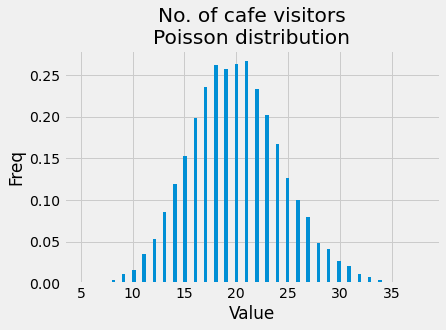

In [4]:
# Num of people visiting your local cafe assuming Poisson distr (per hour)
cafe = stats.poisson(20)

# Plot
plot_distr(cafe, title='No. of cafe visitors')

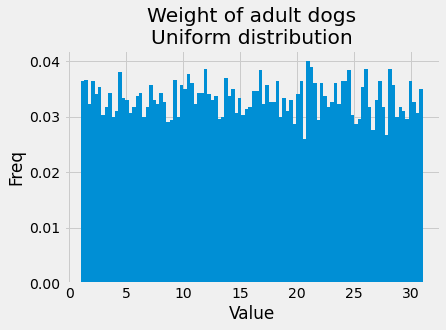

In [5]:
# Weight of adult dogs assuming the Uniform distribution
dogs = stats.uniform(1, 30)

# PLot
plot_distr(dogs, title='Weight of adult dogs')

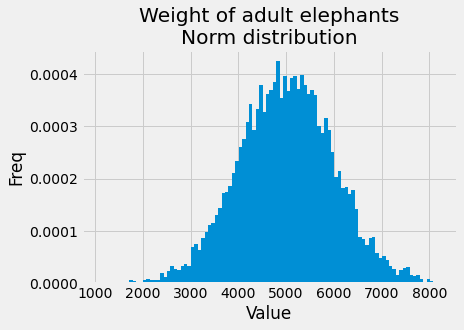

In [6]:
# Weight of adult dogs assuming the Normal distribution
dogs = stats.norm(5000, 1000)

# PLot
plot_distr(dogs, title='Weight of adult elephants')

## 1E7

Compare Beta priors

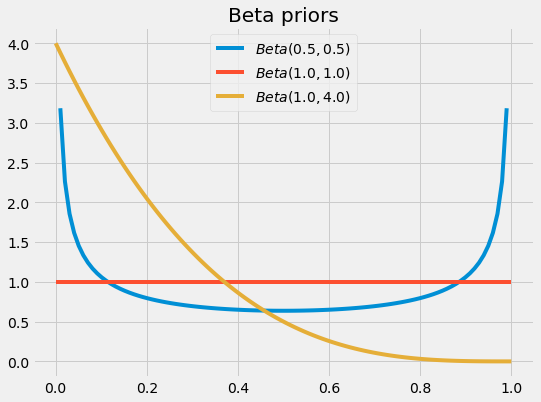

In [7]:
# Define prior parameters
params = [
    (.5, .5),
    (1., 1.),
    (1., 4.),
]

# Generate support
x = np.linspace(0., 1., 100)

plt.figure(figsize=(8, 6))

for param_set in params:
    pdf = stats.beta(*param_set).pdf(x)
    plt.plot(x, pdf, label=f'$Beta{param_set}$')
    
plt.legend()
plt.title('Beta priors')
plt.show()

## 1E8

Re-run code block 1.8 with different beta params 

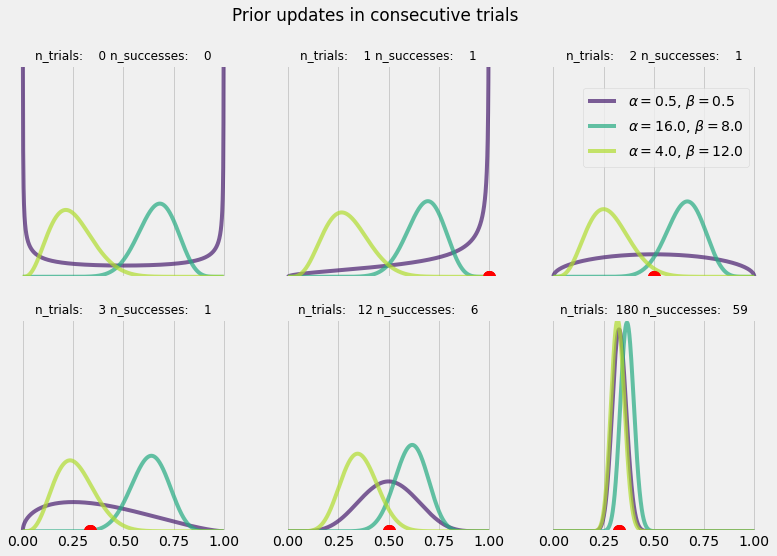

In [8]:
# Generate data
n_trials = [0, 1, 2, 3, 12, 180]
n_success = [0, 1, 1, 1, 6, 59]
data = zip(n_trials, n_success)

# Define  priors
beta_prior_params = [
    (.5, .5),
    (16., 8.),
    (4., 12.)]

# Define parameter space
theta = np.linspace(0, 1, 1500)

# Prepare plotting structure
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
axes = np.ravel(axes)

# Iterate over data
for i, (n, y) in enumerate(data):
    
    # Iterate over Beta priors
    for j, (alpha_prior, beta_prior) in enumerate(beta_prior_params):
        
        # Compute posterior given prior and data
        p_theta_given_y = stats.beta(alpha_prior + y, beta_prior + n - y).pdf(theta)
        
        # Compute the point estimate
        point_estimate = safe_zero_divide(y, n)
        
        # Plot the posterior
        if i == len(n_trials) - 1:
            axes[i].plot(theta, p_theta_given_y, lw=4, color=viridish[j], 
                         label=f'$\\alpha={alpha_prior}$, $\\beta={beta_prior}$', alpha=.7)
        else:
            axes[i].plot(theta, p_theta_given_y, lw=4, color=viridish[j], alpha=.7)
            
        # Plot point estimate
        axes[i].plot(point_estimate, 0, color='red', marker='o', ms=12) 
            
        # Set ticks 
        axes[i].set_yticks([])
        axes[i].set_ylim(0, 12)
        
        # Add title
        axes[i].set_title(f'n_trials: {n:4d} n_successes: {y:4d}', fontsize=12)
        
fig.suptitle('Prior updates in consecutive trials')
fig.legend(loc=(.75, .7))
        
plt.show()

## 1E9

Try to come up with new constraints for MaxEnt priors (code block 1.9)

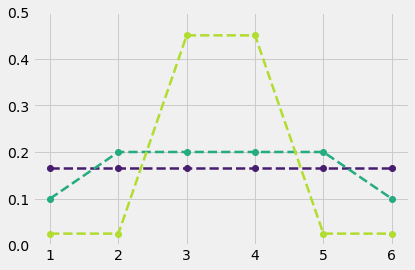

In [9]:
cons = [
    {
        'type': 'eq',
        'fun': lambda x: np.sum(x) - 1
    },
    [
        {
            'type': 'eq',
            'fun': lambda x: np.sum(x) - 1
        },
        {
            'type': 'eq',
            'fun': lambda x: np.sum(x[[1, 2, 3, 4]]) - .8
        }
    ],
    [
        {
            'type': 'eq',
            'fun': lambda x: np.sum(x) - 1
        },
        {
            'type': 'eq',
            'fun': lambda x: np.sum(x[[2, 3]]) - .90
        }
    ],
    
]

max_ent = []

for i, c in enumerate(cons):
    
    val = scipy.optimize.minimize(
        lambda x: -stats.entropy(x),
        x0=[1/6]*6,
        bounds=[(0., 1.)]*6,
        constraints=c)['x']
    
    max_ent.append(val)
    plt.plot(np.arange(1, 7), val, 'o--', color=viridish[i], lw=2.5)

plt.ylim(0, .5)
plt.show()

## 1E12

In [10]:
def posterior_grid(grid=10, a=1, b=1, heads=6, trials=9):
    
    # Build a grid
    grid = np.linspace(0, 1, grid)
    
    # Compute prior, likelihhod and posterior
    prior = stats.beta(a, b).pdf(grid)
    likelihood = stats.binom.pmf(heads, trials, grid)
    posterior = prior * likelihood
    
    # Normalize posterior
    posterior /= posterior.sum()
    
    # Configure plotting
    _, ax = plt.subplots(1, 3, sharex=True, figsize=(16, 4))
    ax[0].set_title(f'Heads = {heads}\nTrials = {trials}')
    
    for i, (distr, distr_name) in enumerate(
        zip(
            [prior, likelihood, posterior],
            ['prior', 'likelihood', 'posterior']
        )):
        ax[i].set_yticks([])
        ax[i].plot(grid, distr, 'o-', label=distr_name)
        ax[i].legend()

In [13]:
ipyw.interact(
    posterior_grid,
    grid=ipyw.IntSlider(min=2, max=100, step=1, value=15),
    a=ipyw.FloatSlider(min=1, max=7, step=1, value=1),
    b=ipyw.FloatSlider(min=1, max=7, step=1, value=1),
    heads=ipyw.IntSlider(min=0, max=20, step=1, value=6),
    trials=ipyw.IntSlider(min=0, max=20, step=1, value=9)
)

interactive(children=(IntSlider(value=15, description='grid', min=2), FloatSlider(value=1.0, description='a', …

<function __main__.posterior_grid(grid=10, a=1, b=1, heads=6, trials=9)>